In [1]:
# Author: Matthew Dixon
# Version: 1.0 (25.8.2018)
# License: MIT
# Email: matthew.dixon@iit.edi
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0

In [6]:
import tensorflow as tf
import numpy as np
#import numpy
#import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import cycle, islice
#%matplotlib inline

# Overview

This tutorial demonstrates the configuration and properties of feed forward neural networks. We will investigate how the perceptron units transform the input space. Specifically, we shall study the fitted weights and plot the separating hyperplanes, starting with no hidden layers, adding a hidden layer and then two hidden layers. We shall also observe the effect of changing the number of perceptron units in a layer.




# Preliminaries

##  Load the standard dataset and other preliminaries

In [7]:
X,Y = make_moons(n_samples=100, noise=0)

In [8]:
plt.figure(figsize=(3, 3))

In [9]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(1 + 1))))

## Function definitions

In [49]:
# Define the baseline neural network binary classifier without a hidden layer (i.e. a logit model)
def create_logit():
# create model
   model = Sequential()
   model.add(Dense(1, input_dim=2, kernel_initializer='normal', activation='sigmoid')) # output layer

# Compile model
   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   return model

In [11]:
# plotting function
def plot_decision_surface(X, model, h):

  x_min, x_max = X[:, 0].min(), X[:, 0].max()
  y_min, y_max = X[:, 1].min(), X[:, 1].max()

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, m_max]x[y_min, y_max].
  y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
  g_pred = np.array(y_pred > 0.5, dtype=np.integer)

  plt.scatter(xx.ravel(), yy.ravel(), s=10, color=colors[g_pred.ravel()])

  plt.scatter(X[:, 0], X[:, 1], s=30, color=colors[Y],edgecolors='black')
  plt.xlabel(r'$X_1$')
  plt.ylabel(r'$X_2$')

  return plt

In [12]:
def logit(x):
    return 1 / (1 + np.exp(-x))

In [13]:
# fix random seed for reproducibility
seed = 55
np.random.seed(seed)

## Part 1a: Evaluate the logit model

In [14]:
# Partition the iid data for training and testing. In this example, we shall only consider training data since our goal 
# is to understand how adding hidden layers transforms the input space.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0, random_state=seed)
# build
model = create_logit()
model.fit(X_train, Y_train, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
100/100 [==============================] - 0s 4ms/step - loss: 0.7062 - acc: 0.3000
Epoch 2/300
100/100 [==============================] - 0s 2ms/step - loss: 0.6812 - acc: 0.7300
Epoch 3/300
100/100 [==============================] - 0s 2ms/step - loss: 0.6576 - acc: 0.8700
Epoch 4/300
100/100 [==============================] - 0s 2ms/step - loss: 0.6360 - acc: 0.8600
Epoch 5/300
100/100 [==============================] - 0s 2ms/step - loss: 0.6152 - acc: 0.8400
Epoch 6/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5961 - acc: 0.8400
Epoch 7/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5783 - acc: 0.8400
Epoch 8/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5617 - acc: 0.8300
Epoch 9/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5466 - acc: 0.8400
Epoch 10/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5318 - acc: 0.8400
Epoch 11/300
100/100 [=================

100/100 [==============================] - 0s 2ms/step - loss: 0.2667 - acc: 0.8700
Epoch 168/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2667 - acc: 0.8700
Epoch 169/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2665 - acc: 0.8700
Epoch 170/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2664 - acc: 0.8700
Epoch 171/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2662 - acc: 0.8700
Epoch 172/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2662 - acc: 0.8700
Epoch 173/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2661 - acc: 0.8700
Epoch 174/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2659 - acc: 0.8700
Epoch 175/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2659 - acc: 0.8700
Epoch 176/300
100/100 [==============================] - 0s 2ms/step - loss: 0.2658 - acc: 0.8700
Epoch 177/300
100/100 [===========

## Predict response on training set

In [31]:
y_pred = model.predict(X_train)
g_pred = (y_pred > 0.5)

## Analysis of the logit model

In [32]:
W1,b1 = model.layers[0].get_weights()

In [33]:
# Let's compare the prediction from the reconstructed logit model with tensorflow to verify that they are the same
for i in range(0,len(X_train)):
 x=X_train[i]
 y_hat=logit(np.matmul(np.transpose(W1),x) + b1)
 print y_hat, y_pred[i]  

[0.01512315] [0.01512314]
[0.82068598] [0.820686]
[0.99010136] [0.99010134]
[0.10930842] [0.10930842]
[0.00899281] [0.00899281]
[0.75178501] [0.751785]
[0.95734597] [0.95734596]
[0.22000111] [0.22000113]
[0.94484258] [0.9448426]
[0.92940393] [0.9294039]
[0.98075033] [0.9807504]
[0.987086] [0.987086]
[0.98563002] [0.98563]
[0.01767695] [0.01767694]
[0.67943052] [0.67943054]
[0.74626358] [0.7462635]
[0.45107699] [0.45107695]
[0.35972837] [0.35972837]
[0.8819461] [0.88194615]
[0.97670223] [0.9767022]
[0.85040047] [0.8504005]
[0.9770876] [0.9770876]
[0.10672976] [0.10672978]
[0.97225086] [0.9722509]
[0.37656929] [0.37656927]
[0.01066243] [0.01066243]
[0.53633597] [0.536336]
[0.93099268] [0.93099266]
[0.08218055] [0.08218057]
[0.12493009] [0.12493009]
[0.98721112] [0.9872111]
[0.99019938] [0.9901994]
[0.03140136] [0.03140137]
[0.98352753] [0.9835276]
[0.0091009] [0.0091009]
[0.01334433] [0.01334433]
[0.02140153] [0.02140154]
[0.04969723] [0.04969722]
[0.60283708] [0.6028371]
[0.01532675] [0

## Plot the separating hyperplanes

In [34]:
x_min = min(X[:,0])
x_max = max(X[:,0])


y1 = -(b1 + W1[0]*x_min)/W1[1]
y2 = -(b1 + W1[0]*x_max)/W1[1]


In [35]:
plt.scatter(X[:, 0], X[:, 1], s=30, color=colors[Y])
plt.plot([x_min, x_max], [y1, y2], color='k', linestyle='-', linewidth=2)
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')

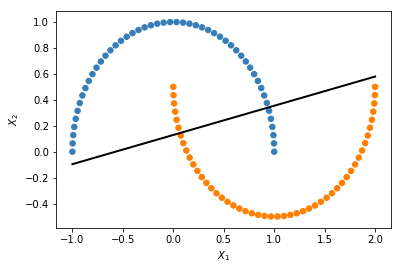

In [36]:
plt.show()

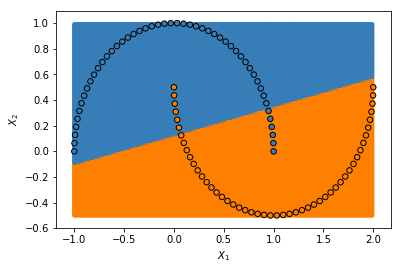

In [37]:
plt = plot_decision_surface(X, model, 0.01)
plt.show()

## Part 1b: Analysis of a FFWD Neural Network with one hidden layer

In [38]:
def create_model_h1():
# create model
   model = Sequential()
   model.add(Dense(2, input_dim=2, kernel_initializer='normal', activation='relu'))
   #model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
   model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# Compile model
   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   return model

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.0, random_state=seed)

# build
model_h1 = create_model_h1()
model_h1.fit(X_train, Y_train, epochs=200, batch_size=1, verbose=1)

Epoch 1/200
100/100 [==============================] - 0s 4ms/step - loss: 0.6924 - acc: 0.5600
Epoch 2/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6875 - acc: 0.6200
Epoch 3/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6723 - acc: 0.8200
Epoch 4/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6511 - acc: 0.8300
Epoch 5/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6247 - acc: 0.8400
Epoch 6/200
100/100 [==============================] - 0s 2ms/step - loss: 0.5951 - acc: 0.8400
Epoch 7/200
100/100 [==============================] - 0s 2ms/step - loss: 0.5644 - acc: 0.8400
Epoch 8/200
100/100 [==============================] - 0s 3ms/step - loss: 0.5333 - acc: 0.8400
Epoch 9/200
100/100 [==============================] - 0s 3ms/step - loss: 0.5040 - acc: 0.8400
Epoch 10/200
100/100 [==============================] - 0s 2ms/step - loss: 0.4769 - acc: 0.8400
Epoch 11/200
100/100 [=================

100/100 [==============================] - 0s 2ms/step - loss: 0.2624 - acc: 0.8800
Epoch 169/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2623 - acc: 0.8800
Epoch 170/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2619 - acc: 0.8800
Epoch 171/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2620 - acc: 0.8800
Epoch 172/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2616 - acc: 0.8800
Epoch 173/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2617 - acc: 0.8800
Epoch 174/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2617 - acc: 0.8800
Epoch 175/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2623 - acc: 0.8800
Epoch 176/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2619 - acc: 0.8800
Epoch 177/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2627 - acc: 0.8800
Epoch 178/200
100/100 [===========

In [39]:
Z1 = [0]*len(X)
Z2 = [0]*len(X)
W1,b1 = model_h1.layers[0].get_weights()
W2,b2 = model_h1.layers[1].get_weights()

for i in range(len(X)):
    x = X[i]
    Z1[i], Z2[i] =np.maximum(np.matmul(np.transpose(W1),x) + b1,0)

Let's view the input after transformation through hidden layer 1.

In [43]:
plt.scatter(Z1, Z2, s=30, color=colors[Y])

W2=W2.ravel()
z1_min=min(Z1)
z1_max=max(Z1)

z1 = -(b2 + W2[0]*z1_min)/W2[1]
z2 = -(b2 + W2[0]*z1_max)/W2[1]

plt.plot([z1_min, z1_max], [z1, z2], color='k', linestyle='-', linewidth=2)
plt.xlabel(r'$Z^{(1)}_1$')
plt.ylabel(r'$Z^{(1)}_2$')

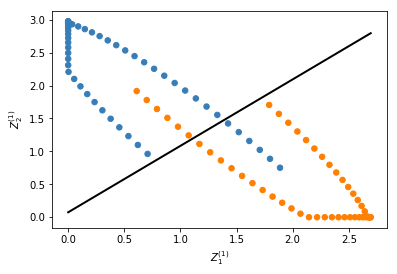

In [44]:
plt.show()

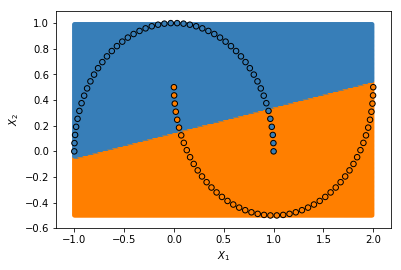

In [45]:
plt = plot_decision_surface(X, model_h1, 0.01)
plt.show()

## Part 1c: Analysis of FFWD Neural Network Model with Two Hidden Layers

In [50]:
def create_model_h2():
# create model
   model = Sequential()
   model.add(Dense(2, input_dim=2, kernel_initializer='normal', activation='relu')) # hidden layer 1
   model.add(Dense(2, kernel_initializer='normal', activation='relu'))              # hidden layer 2
   model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))           # final layer

# Compile model
   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   return model

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.0, random_state=seed)

# build
model_h2 = create_model_h2()
model_h2.fit(X_train, Y_train, epochs=200, batch_size=1, verbose=1)

Epoch 1/200
100/100 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.5000
Epoch 2/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6927 - acc: 0.5700
Epoch 3/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6897 - acc: 0.7700
Epoch 4/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6818 - acc: 0.7800
Epoch 5/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6683 - acc: 0.6600
Epoch 6/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6494 - acc: 0.7500
Epoch 7/200
100/100 [==============================] - 0s 3ms/step - loss: 0.6276 - acc: 0.8100
Epoch 8/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6035 - acc: 0.8100
Epoch 9/200
100/100 [==============================] - 0s 2ms/step - loss: 0.5810 - acc: 0.8200
Epoch 10/200
100/100 [==============================] - 0s 2ms/step - loss: 0.5603 - acc: 0.8200
Epoch 11/200
100/100 [=================

100/100 [==============================] - 0s 2ms/step - loss: 0.2775 - acc: 0.8800
Epoch 169/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2779 - acc: 0.8800
Epoch 170/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2780 - acc: 0.8800
Epoch 171/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2783 - acc: 0.8800
Epoch 172/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2781 - acc: 0.8800
Epoch 173/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2769 - acc: 0.8800
Epoch 174/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2782 - acc: 0.8800
Epoch 175/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2791 - acc: 0.8800
Epoch 176/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2768 - acc: 0.8800
Epoch 177/200
100/100 [==============================] - 0s 2ms/step - loss: 0.2766 - acc: 0.8800
Epoch 178/200
100/100 [===========

In [51]:
Z1 = [0]*len(X)
Z2 = [0]*len(X)

W1,b1 = model_h2.layers[0].get_weights()
W2,b2 = model_h2.layers[1].get_weights()
W3,b3 = model_h2.layers[2].get_weights()

for i in range(len(X)):
    x = X[i]
    z =np.maximum(np.matmul(np.transpose(W1),x) + b1,0)
    Z1[i], Z2[i] =np.maximum(np.matmul(np.transpose(W2),z) + b2,0)
    

Let's view the input after transformation through hidden layer 1 and 2.

In [58]:
plt.scatter(Z1, Z2, s=30, color=colors[Y])

W3=W3.ravel()
z1_min=min(Z1)
z1_max=max(Z1)

z1 = -(b3 + W3[0]*z1_min)/W3[1]
z2 = -(b3 + W3[0]*z1_max)/W3[1]

plt.plot([z1_min, z1_max], [z1, z2], color='k', linestyle='-', linewidth=2)
plt.xlabel(r'$Z^{(2)}_1$')
plt.ylabel(r'$Z^{(2)}_2$')

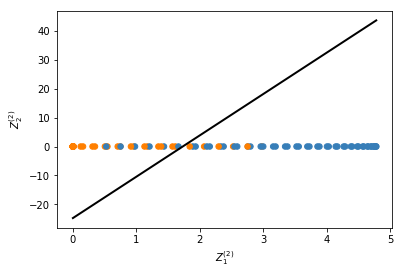

In [59]:
plt.show()

In [60]:
plt = plot_decision_surface(X, model_h2, 0.01)

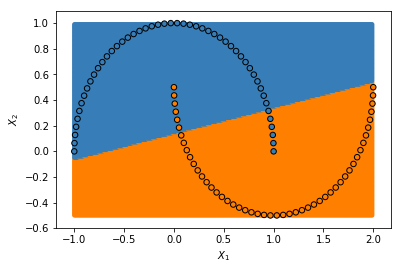

In [61]:
plt.show()

## Model H1: many hidden units

In [ ]:
def create_model_h1_many():
# create model
   model = Sequential()
   model.add(Dense(75, input_dim=2, kernel_initializer='normal', activation='relu')) # hidden layer
   model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))            # output layer

# Compile model
   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   return model

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0, random_state=seed)
# build
model_h1_many = create_model_h1_many()
model_h1_many.fit(X_train, Y_train, epochs=300, batch_size=1, verbose=1)

In [ ]:
Z1 = [0]*len(X)
Z2 = [0]*len(X)
W1,b1 = model_h1_many.layers[0].get_weights()
W2,b2 = model_h1_many.layers[1].get_weights()

for i in range(len(X)):
    x = X[i]
    Z1[i], Z2[i] =np.maximum(np.matmul(np.transpose(W1),x) + b1,0)[0:2]

### dimensionality of Z is much higher than 2

In [ ]:
plt.scatter(Z1, Z2, s=30, color=colors[Y])

W2=W2.ravel()
z1_min=min(Z1)
z1_max=max(Z1)

z1 = -(b2 + W2[0]*z1_min)/W2[1]
z2 = -(b2 + W2[0]*z1_max)/W2[1]

plt.plot([z1_min, z1_max], [z1, z2], color='k', linestyle='-', linewidth=2)
plt.xlabel(r'$Z^{(1)}_1$')
plt.ylabel(r'$Z^{(1)}_2$')

In [ ]:
plt.show()

In [ ]:
plt = plot_decision_surface(X, model_h1_many, 0.01)

In [ ]:
#plt.savefig('NN1_h75.jpeg')
plt.show()

## Part 2: How many hidden units?

We can also study the effect of changing the number if perceptron units. Staying with the two layer model and repeating the analysis above..

In [63]:
def create_model_h2_many():
# create model
   model = Sequential()
   model.add(Dense(50, input_dim=2, kernel_initializer='normal', activation='relu'))
   model.add(Dense(2, kernel_initializer='normal', activation='relu'))
   model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# Compile model
   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   return model

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0, random_state=seed)
# build
model_h2_many = create_model_h2_many()
model_h2_many.fit(X_train, Y_train, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
100/100 [==============================] - 1s 6ms/step - loss: 0.6904 - acc: 0.5000
Epoch 2/300
100/100 [==============================] - 0s 3ms/step - loss: 0.6624 - acc: 0.7500
Epoch 3/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5900 - acc: 0.7900
Epoch 4/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5343 - acc: 0.8400
Epoch 5/300
100/100 [==============================] - 0s 2ms/step - loss: 0.5074 - acc: 0.8500
Epoch 6/300
100/100 [==============================] - 0s 2ms/step - loss: 0.4915 - acc: 0.8400
Epoch 7/300
100/100 [==============================] - 0s 2ms/step - loss: 0.4774 - acc: 0.8400
Epoch 8/300
100/100 [==============================] - 0s 2ms/step - loss: 0.4679 - acc: 0.8500
Epoch 9/300
100/100 [==============================] - 0s 2ms/step - loss: 0.4562 - acc: 0.8600
Epoch 10/300
100/100 [==============================] - 0s 3ms/step - loss: 0.4467 - acc: 0.8700
Epoch 11/300
100/100 [=================

100/100 [==============================] - 0s 2ms/step - loss: 0.0032 - acc: 1.0000
Epoch 169/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 1.0000
Epoch 170/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0031 - acc: 1.0000
Epoch 171/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0029 - acc: 1.0000
Epoch 172/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 1.0000
Epoch 173/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0027 - acc: 1.0000
Epoch 174/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0026 - acc: 1.0000
Epoch 175/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0025 - acc: 1.0000
Epoch 176/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0024 - acc: 1.0000
Epoch 177/300
100/100 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 1.0000
Epoch 178/300
100/100 [===========

In [65]:
Z1 = [0]*len(X)
Z2 = [0]*len(X)

W1,b1 = model_h2_many.layers[0].get_weights()
W2,b2 = model_h2_many.layers[1].get_weights()
W3,b3 = model_h2_many.layers[2].get_weights()

for i in range(len(X)):
    x = X[i]
    z =np.maximum(np.matmul(np.transpose(W1),x) + b1,0)
    Z1[i], Z2[i] =np.maximum(np.matmul(np.transpose(W2),z) + b2,0)

In [66]:
plt.scatter(Z1, Z2, s=30, color=colors[Y])

W3=W3.ravel()
z1_min=min(Z1)
z1_max=max(Z1)

z1 = -(b3 + W3[0]*z1_min)/W3[1]
z2 = -(b3 + W3[0]*z1_max)/W3[1]

plt.plot([z1_min, z1_max], [z1, z2], color='k', linestyle='-', linewidth=2)
plt.xlabel(r'$Z^{(2)}_1$')
plt.ylabel(r'$Z^{(2)}_2$')

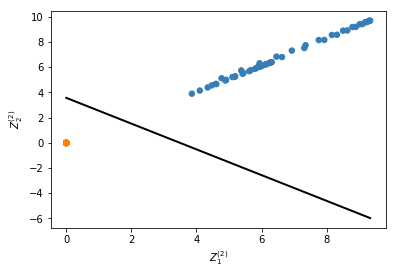

In [67]:
plt.show()

In [68]:
plt = plot_decision_surface(X, model_h2_many, 0.01)

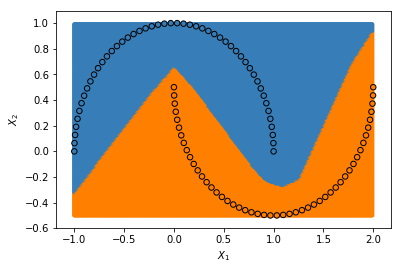

In [69]:
plt.show()

## Questions/Exercises

### 1) Did we need more than one hidden layer to perfectly classify? If not, why might multiple hidden layers be useful for other datasets?
### 2) Why not use a very large number of neurons since it's clear that the classification accuracy improves with more degrees of freedom?
### 3) Repeat the plotting of the hyperplane, in Part 1b, only without the ReLU function (i.e. max(x, 0) function). Why is an activation function needed?